# Skin Lesion Classification with CNN (HAM10000)

**Student:** Van Anh PHAM (5005870)

**Course:** Advanced Programming and Deep Learning for AI

**Dataset:** HAM10000 (augmented, ~39,500 images, 7 classes)  

## Project Overview

The goal of this project is to build a **Convolutional Neural Network (CNN)** from scratch to classify **dermoscopic images of skin lesions** into 7 categories:

- **akiec**: Actinic keratoses and intraepithelial carcinoma  
- **bcc**: Basal cell carcinoma  
- **bkl**: Benign keratosis-like lesions  
- **df**: Dermatofibroma  
- **mel**: Melanoma  
- **nv**: Melanocytic nevi  
- **vasc**: Vascular lesions  



In [ ]:
!pip install -q kagglehub kaggle pandas scikit-learn torchvision pillow matplotlib

## Step 1 — Download Dataset with KaggleHub

In this step, we download the **HAM10000 augmented skin cancer dataset** using `kagglehub`.  

- `kagglehub.dataset_download()` will automatically fetch the dataset from Kaggle and cache it locally.  
- If it’s already cached, it won’t re-download, which saves time.  
- We set `WORK_DIR` to point to the dataset directory, so we can use it later for loading images.  
- Finally, we print out the dataset folder path and its contents to confirm everything was downloaded correctly.

In [ ]:
import kagglehub, os

DATASET_HANDLE = "utkarshps/skin-cancer-mnist10000-ham-augmented-dataset"

path = kagglehub.dataset_download(DATASET_HANDLE)

WORK_DIR = path
print("Dataset folder:", WORK_DIR)

print("Contents:", os.listdir(WORK_DIR))

Resuming download from 926941184 bytes (2042639038 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/utkarshps/skin-cancer-mnist10000-ham-augmented-dataset?dataset_version_number=1 (926941184/2969580222) bytes left.


100%|██████████| 2.77G/2.77G [01:32<00:00, 22.2MB/s]

Extracting files...


Dataset folder: /root/.cache/kagglehub/datasets/utkarshps/skin-cancer-mnist10000-ham-augmented-dataset/versions/1
Contents: ['base_dir']


## Step 2 — Setup
Here we import all necessary libraries (PyTorch, torchvision, sklearn, etc.),  
set a random seed for reproducibility.


In [ ]:
import os, glob, random, numpy as np, pandas as pd
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Step 3 — Build DataFrame
We scan the dataset folders to find all image files.  
Each image is linked to its **class label** (the folder name).  
We store this information in a Pandas DataFrame with columns:
- filepath  
- label (string)  
- label_idx (numeric encoding)  

This will make it easier to split and feed data into PyTorch.


In [ ]:
import os, glob, pandas as pd

def find_images_recursive(base):
    exts = (".jpg",".jpeg",".png",".bmp",".tif",".tiff")
    return [p for p in glob.glob(os.path.join(base, "**", "*"), recursive=True)
            if os.path.splitext(p)[1].lower() in exts]

all_images = find_images_recursive(WORK_DIR)
print("Found image files:", len(all_images))

rows = []
for p in all_images:
    label = os.path.basename(os.path.dirname(p)).lower().strip()
    if label:
        rows.append((p, label))

df_all = pd.DataFrame(rows, columns=["filepath","label"]).dropna().reset_index(drop=True)
class_names = sorted(df_all["label"].unique())
label_to_idx = {c:i for i,c in enumerate(class_names)}
df_all["label_idx"] = df_all["label"].map(label_to_idx).astype(int)

print("Classes:", class_names)
print("Total images:", len(df_all))
df_all["label"].value_counts()

Found image files: 39507
Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Total images: 39507


,count
label,
nv,6705
bkl,5995
mel,5959
bcc,5888
vasc,5301
akiec,5243
df,4416


## Step 4 — Train/Val/Test Split
We we split the data into:
- 70% training set  
- 10% validation set  
- 20% test set  

Splits are **stratified**, meaning class proportions are preserved.

In [ ]:
from sklearn.model_selection import train_test_split

subset_fraction = None

df_use = df_all.copy()
if subset_fraction is not None:
    df_use, _ = train_test_split(
        df_use, train_size=subset_fraction,
        stratify=df_use["label_idx"], random_state=SEED
    )
print(f"Using {len(df_use)} images out of {len(df_all)}")

train_df, tmp_df = train_test_split(df_use, test_size=0.30,
                                    stratify=df_use["label_idx"], random_state=SEED)
val_df, test_df = train_test_split(tmp_df, test_size=2/3,
                                   stratify=tmp_df["label_idx"], random_state=SEED)

n_classes = len(class_names)
print("Split sizes — train:", len(train_df), "| val:", len(val_df), "| test:", len(test_df))


Using 39507 images out of 39507
Split sizes — train: 27654 | val: 3951 | test: 7902


### Peek at Sample Images
Here we display 12 random images from the training set with their labels.  
This helps us visually confirm that images and labels are correct.

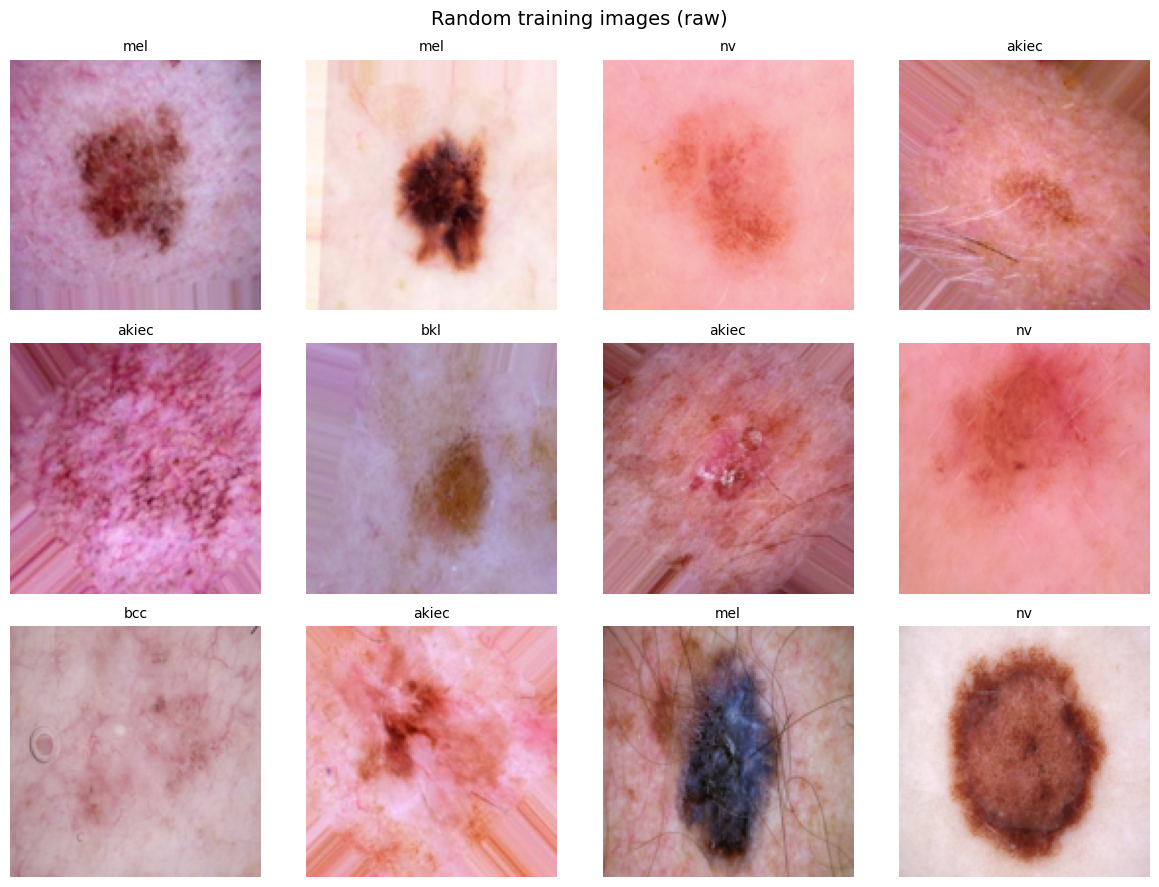

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

IMSIZE_FOR_PEEK = 128
sample = train_df.sample(12, random_state=SEED).reset_index(drop=True)

rows, cols = 3, 4
plt.figure(figsize=(12, 9))
for i in range(rows*cols):
    fp  = sample.loc[i, "filepath"]
    lbl = sample.loc[i, "label"]
    img = Image.open(fp).convert("RGB").resize((IMSIZE_FOR_PEEK, IMSIZE_FOR_PEEK))
    ax = plt.subplot(rows, cols, i+1)
    ax.imshow(img)
    ax.set_title(lbl, fontsize=10)
    ax.axis("off")
plt.suptitle("Random training images (raw)", fontsize=14)
plt.tight_layout()
plt.show()

## Step 5 — Transforms and DataLoaders
We define image **preprocessing pipelines**:
- Training: resize → random flip → random rotation → color jitter → normalize  
- Validation/Test: resize → normalize  

Then we create **PyTorch Dataset** and **DataLoader** objects:
- Dataset = provides one (image, label) pair  
- DataLoader = batches multiple samples for training


In [ ]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch

IMSIZE = 160

train_tf = transforms.Compose([
    transforms.Resize((IMSIZE, IMSIZE)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(12),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.02),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

eval_tf = transforms.Compose([
    transforms.Resize((IMSIZE, IMSIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

class SimpleImageDataset(Dataset):
    def __init__(self, df, tf):
        self.df = df.reset_index(drop=True)
        self.tf = tf
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        row = self.df.iloc[i]
        img = Image.open(row["filepath"]).convert("RGB")
        x = self.tf(img)
        y = int(row["label_idx"])
        return x, y

train_ds = SimpleImageDataset(train_df, train_tf)
val_ds   = SimpleImageDataset(val_df,   eval_tf)
test_ds  = SimpleImageDataset(test_df,  eval_tf)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_gpu = torch.cuda.is_available()
NUM_WORKERS = 2 if use_gpu else 0
PIN_MEMORY  = use_gpu

BATCH_SIZE  = 64

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

xb, yb = next(iter(train_loader))
print("Batch shape:", xb.shape, "| labels sample:", yb[:8].tolist())


Batch shape: torch.Size([64, 3, 160, 160]) | labels sample: [2, 2, 1, 2, 2, 0, 5, 4]


## Step 6 — Model: Small ResNet (from scratch)
We define a **custom CNN architecture** inspired by ResNet.  
It uses **residual blocks** (skip connections) which help with gradient flow and training stability.  

The model structure is:
- Stem: conv + BN + ReLU  
- 4 stages of residual blocks (downsampling with stride=2)  
- Global Average Pooling  
- Fully-connected layer → 7-class output  



In [ ]:
import torch.nn as nn
import torch

class BasicBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_ch)
        self.down  = None
        if stride != 1 or in_ch != out_ch:
            self.down = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_ch)
            )
    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.down is not None:
            identity = self.down(identity)
        return self.relu(out + identity)

class SmallResNet(nn.Module):
    def __init__(self, num_classes=7, width=32, p_drop=0.25):
        super().__init__()
        c = width
        self.stem = nn.Sequential(
            nn.Conv2d(3, c, 3, padding=1, bias=False),
            nn.BatchNorm2d(c), nn.ReLU(inplace=True)
        )
        self.layer1 = nn.Sequential(BasicBlock(c,   c,   stride=1),
                                    BasicBlock(c,   c,   stride=1))  # 128 -> 128
        self.layer2 = nn.Sequential(BasicBlock(c,   c*2, stride=2),
                                    BasicBlock(c*2, c*2, stride=1))  # 128 -> 64
        self.layer3 = nn.Sequential(BasicBlock(c*2, c*4, stride=2),
                                    BasicBlock(c*4, c*4, stride=1))  # 64  -> 32
        self.layer4 = nn.Sequential(BasicBlock(c*4, c*4, stride=2),
                                    BasicBlock(c*4, c*4, stride=1))  # 32  -> 16
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), nn.Flatten(),
            nn.Dropout(p_drop),
            nn.Linear(c*4, num_classes)
        )
    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x); x = self.layer2(x); x = self.layer3(x); x = self.layer4(x)
        return self.head(x)

model = SmallResNet(num_classes=n_classes, width=32, p_drop=0.25).to(DEVICE)
print("SmallResNet params:", sum(p.numel() for p in model.parameters() if p.requires_grad))


SmallResNet params: 1303719


## Step 7 — Loss Function & Optimizer
We use **CrossEntropyLoss** with **class weights** to handle dataset imbalance.  
We also add **label smoothing** (0.05) for stability.  
Optimizer: **Adam** with learning rate = 1e-3 and weight decay = 1e-4.  

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

y_train = train_df["label_idx"].values
weights = compute_class_weight(class_weight="balanced",
                               classes=np.arange(n_classes), y=y_train)
class_weights = torch.tensor(weights, dtype=torch.float32, device=DEVICE)
print("Class weights:", class_weights.cpu().numpy())

def loss_fn(logits, y):
    return F.cross_entropy(logits, y, weight=class_weights, label_smoothing=0.05)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)


Class weights: [1.07645    0.95841134 0.94150895 1.2780885  0.9471521  0.84180087
 1.0645571 ]


## Step 8 — Training Loop with Early Stopping
We train the model for up to 20 epochs.  
At each epoch:
- Compute training loss/accuracy  
- Compute validation loss/accuracy  

We track the **best validation accuracy** and stop early if validation does not improve after 4 epochs (patience).


In [ ]:
from copy import deepcopy

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    loss_sum, correct, n = 0.0, 0, 0
    for xb, yb in loader:
        xb = xb.to(device); yb = yb.to(device)
        logits = model(xb)
        loss = loss_fn(logits, yb)
        loss_sum += loss.item() * yb.size(0)
        correct  += (logits.argmax(1) == yb).sum().item()
        n += yb.size(0)
    return loss_sum/n, correct/n

EPOCHS = 20
PATIENCE = 4
best_val, best_state = 0.0, None
bad = 0
history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}

for ep in range(1, EPOCHS+1):
    model.train()
    run_loss, run_correct, seen = 0.0, 0, 0
    for xb, yb in train_loader:
        xb = xb.to(DEVICE); yb = yb.to(DEVICE)
        logits = model(xb)
        loss = loss_fn(logits, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        b = yb.size(0)
        run_loss   += loss.item() * b
        run_correct += (logits.argmax(1) == yb).sum().item()
        seen += b

    tr_loss = run_loss/seen
    tr_acc  = run_correct/seen
    va_loss, va_acc = evaluate(model, val_loader, DEVICE)

    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)

    print(f"Epoch {ep:02d} | train {tr_loss:.4f}/{tr_acc:.4f} | val {va_loss:.4f}/{va_acc:.4f}")

    if va_acc > best_val:
        best_val = va_acc
        best_state = deepcopy({k:v.detach().cpu().clone() for k,v in model.state_dict().items()})
        bad = 0
    else:
        bad += 1
        if bad > PATIENCE:
            print("Early stopping.")
            break

print(f"Best val acc: {best_val:.4f}")
if best_state is not None:
    model.load_state_dict(best_state)


Epoch 01 | train 1.5718/0.4200 | val 1.3707/0.5204
Epoch 02 | train 1.3397/0.5266 | val 1.2428/0.5781
Epoch 03 | train 1.2263/0.5709 | val 1.1886/0.5882
Epoch 04 | train 1.1551/0.6060 | val 1.1719/0.6029
Epoch 05 | train 1.0965/0.6313 | val 1.1467/0.6036
Epoch 06 | train 1.0342/0.6634 | val 1.0718/0.6328
Epoch 07 | train 0.9828/0.6884 | val 1.0029/0.6631
Epoch 08 | train 0.9436/0.6985 | val 1.1706/0.5983
Epoch 09 | train 0.9164/0.7120 | val 0.9724/0.6892
Epoch 10 | train 0.8800/0.7306 | val 0.9534/0.7211
Epoch 11 | train 0.8575/0.7417 | val 0.9193/0.7077
Epoch 12 | train 0.8325/0.7541 | val 0.8581/0.7337
Epoch 13 | train 0.8021/0.7658 | val 0.8535/0.7411
Epoch 14 | train 0.7831/0.7721 | val 0.8144/0.7722
Epoch 15 | train 0.7636/0.7840 | val 0.8375/0.7487
Epoch 16 | train 0.7388/0.7959 | val 0.9602/0.7213
Epoch 17 | train 0.7228/0.7995 | val 0.7428/0.7892
Epoch 18 | train 0.6979/0.8132 | val 0.7745/0.7828
Epoch 19 | train 0.6887/0.8187 | val 0.7278/0.7892
Epoch 20 | train 0.6787/0.8241 

## Step 9 — Learning Curves
We plot the training vs validation:
- Loss curve  
- Accuracy curve  

These plots show whether the model is underfitting, overfitting, or learning well.


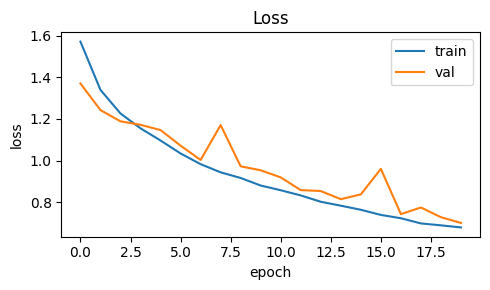

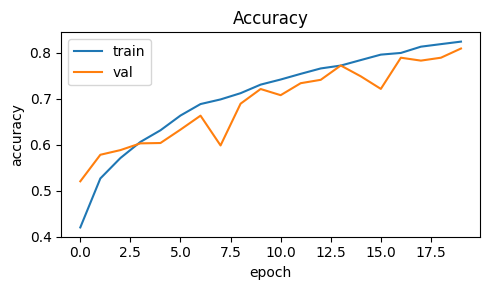

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,3))
plt.plot(history["train_loss"], label="train")
plt.plot(history["val_loss"], label="val")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Loss"); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(5,3))
plt.plot(history["train_acc"], label="train")
plt.plot(history["val_acc"], label="val")
plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.title("Accuracy"); plt.legend(); plt.tight_layout(); plt.show()


## Step 10 — Evaluation: Classification Report & Confusion Matrix
We evaluate on both validation and test sets.  
- **Classification Report**: precision, recall, F1-score per class.  
- **Confusion Matrix**: visualizes misclassifications.  

This helps us see which classes are easiest or hardest for the model.

Validation report:
               precision    recall  f1-score   support

       akiec     0.6300    0.8740    0.7322       524
         bcc     0.8928    0.7789    0.8320       588
         bkl     0.7978    0.4800    0.5994       600
          df     0.9239    0.9344    0.9291       442
         mel     0.6471    0.7416    0.6912       596
          nv     0.8956    0.9076    0.9016       671
        vasc     0.9796    0.9981    0.9888       530

    accuracy                         0.8092      3951
   macro avg     0.8238    0.8164    0.8106      3951
weighted avg     0.8221    0.8092    0.8059      3951



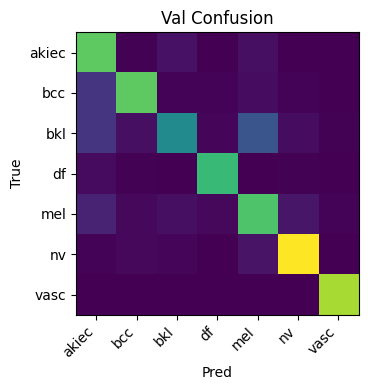

Test report:
               precision    recall  f1-score   support

       akiec     0.6261    0.8923    0.7358      1049
         bcc     0.8735    0.7623    0.8141      1178
         bkl     0.7857    0.4771    0.5937      1199
          df     0.9199    0.9366    0.9282       883
         mel     0.6536    0.7156    0.6832      1192
          nv     0.8779    0.9060    0.8917      1341
        vasc     0.9915    0.9943    0.9929      1060

    accuracy                         0.8042      7902
   macro avg     0.8183    0.8120    0.8057      7902
weighted avg     0.8159    0.8042    0.8004      7902



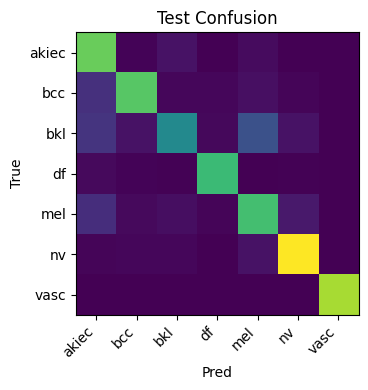

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

@torch.no_grad()
def collect_preds(model, loader, device):
    model.eval()
    preds, trues = [], []
    for xb, yb in loader:
        xb = xb.to(device)
        logits = model(xb)
        preds.append(logits.argmax(1).cpu().numpy())
        trues.append(yb.numpy())
    return np.concatenate(preds), np.concatenate(trues)

# Validation
v_pred, v_true = collect_preds(model, val_loader, DEVICE)
print("Validation report:\n", classification_report(v_true, v_pred, digits=4, target_names=class_names))
cm_val = confusion_matrix(v_true, v_pred)
plt.figure(figsize=(5,4)); plt.imshow(cm_val); plt.title("Val Confusion");
plt.xticks(range(n_classes), class_names, rotation=45, ha="right"); plt.yticks(range(n_classes), class_names);
plt.xlabel("Pred"); plt.ylabel("True"); plt.tight_layout(); plt.show()

# Test
t_pred, t_true = collect_preds(model, test_loader, DEVICE)
print("Test report:\n", classification_report(t_true, t_pred, digits=4, target_names=class_names))
cm_test = confusion_matrix(t_true, t_pred)
plt.figure(figsize=(5,4)); plt.imshow(cm_test); plt.title("Test Confusion");
plt.xticks(range(n_classes), class_names, rotation=45, ha="right"); plt.yticks(range(n_classes), class_names);
plt.xlabel("Pred"); plt.ylabel("True"); plt.tight_layout(); plt.show()


## Step 11 — Final Test Results
We compute the final **test loss and accuracy**.  

In [ ]:
@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    loss_sum, correct, n = 0.0, 0, 0
    for xb, yb in loader:
        xb = xb.to(device); yb = yb.to(device)
        logits = model(xb)
        loss = loss_fn(logits, yb)
        loss_sum += loss.item() * yb.size(0)
        correct  += (logits.argmax(1) == yb).sum().item()
        n += yb.size(0)
    return loss_sum/n, correct/n

test_loss, test_acc = evaluate(model, test_loader, DEVICE)
print(f"Final Test — loss: {test_loss:.4f} | acc: {test_acc:.4f}")


Final Test — loss: 0.7125 | acc: 0.8042
